# Sentiment Analysis of Movie Reviews
## Comprehensive EDA, Preprocessing & SVM Modeling

## 1. Environment Setup
Import required libraries and configure visualization settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
from scipy.sparse import csr_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import drive
from wordcloud import WordCloud
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score, precision_recall_curve,
                             classification_report, ConfusionMatrixDisplay,
                             roc_curve, auc, balanced_accuracy_score)
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
import joblib


nltk.download(['stopwords', 'wordnet', 'omw-1.4', 'punkt_tab'])
plt.style.use('ggplot')
%matplotlib inline
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Data Loading & Initial Inspection
Load dataset and understand basic structure

In [ ]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Separate the training and testing dataset
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

In [ ]:
# Initial inspection
print(f"Training dataset shape: {df_train.shape}")
print(f"Testing dataset shape: {df_test.shape}")

Training dataset shape: (25000, 2)
Testing dataset shape: (25000, 2)


In [ ]:
# Sample data from Training dataset
df_train.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
# Sample data from Testing dataset
df_test.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [ ]:
# Check for missing values for Training dataset
print("Missing Values:")
print(df_train.isnull().sum())

Missing Values:
text     0
label    0
dtype: int64


In [ ]:
# Check for missing values for Testing dataset
print("Missing Values:")
print(df_test.isnull().sum())

Missing Values:
text     0
label    0
dtype: int64


Training Dataset Class Distribution:
label
0    12500
1    12500
Name: count, dtype: int64


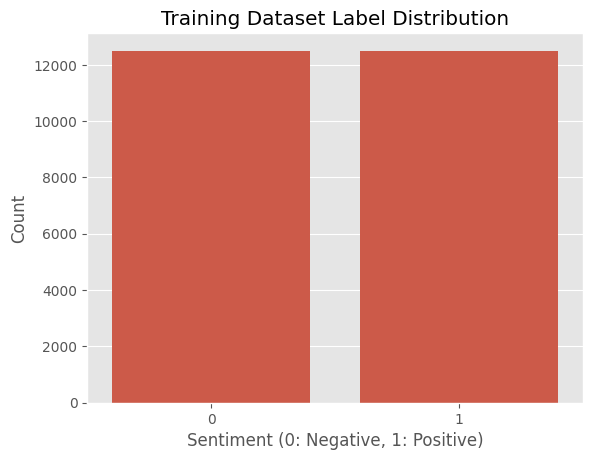

In [ ]:
# Check class distribution for Training dataset
print("Training Dataset Class Distribution:")
print(df_train['label'].value_counts())

sns.countplot(x='label', data=df_train)
plt.title('Training Dataset Label Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

Testing Dataset Class Distribution:
label
0    12500
1    12500
Name: count, dtype: int64


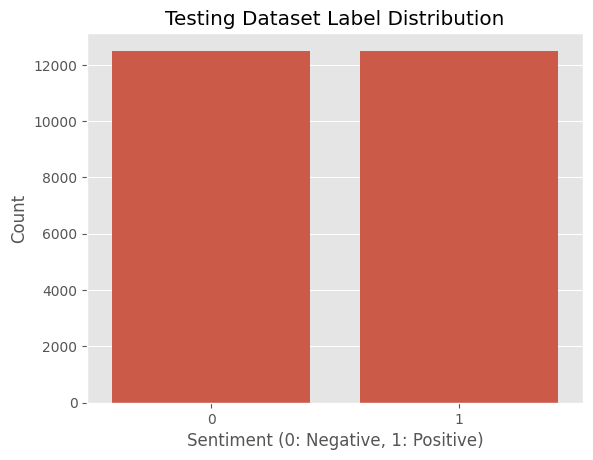

In [ ]:
# Check class distribution for Testing dataset
print("Testing Dataset Class Distribution:")
print(df_test['label'].value_counts())

sns.countplot(x='label', data=df_test)
plt.title('Testing Dataset Label Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

## 3. Text Preprocessing
Clean and normalize text data using NLP techniques

In [ ]:
# Removing HTML tags, special charaters, numbers, extra whitespace, and converting to lowercase
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

In [ ]:
# Define negation terms to exclude from stopwords
negation_words = {'not', 'no', 'never', 'nor', 'neither', 'none', 'nobody', 'nowhere', 'cannot', 'n\'t', 'nt'}

# Update stopwords by removing negation terms
stop_words = set(stopwords.words('english')) - negation_words

In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    words = word_tokenize(text)

    # Lemmatize and remove non-negation stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Handle negation by tagging subsequent words
    processed_words = []
    negation = False
    window = 0  # Number of words to tag after negation

    for word in words:
        if word in negation_words:
            negation = True
            window = 3  # Set window size (adjust as needed)
            processed_words.append(word)
        elif negation:
            processed_words.append(f"{word}_NOT")
            window -= 1
            if window <= 0:
                negation = False
        else:
            processed_words.append(word)

    return ' '.join(processed_words)

In [ ]:
# Apply preprocessing text in both Training and Testing dataset
df_train['cleaned_text'] = df_train['text'].progress_apply(preprocess_text)
df_test['cleaned_text'] = df_test['text'].progress_apply(preprocess_text)

100%|██████████| 25000/25000 [00:39<00:00, 636.27it/s]


## 4. Exploratory Data Analysis (EDA)
Comprehensive visual analysis of the Training dataset

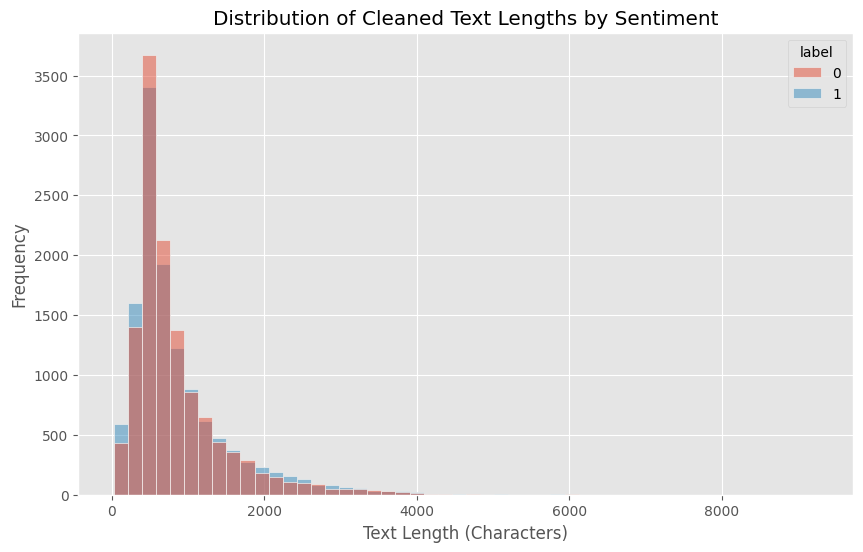

In [ ]:
# Text Length Analysis
df_train['cleaned_text_length'] = df_train['cleaned_text'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(df_train, x='cleaned_text_length', hue='label', bins=50, alpha=0.5)
plt.title('Distribution of Cleaned Text Lengths by Sentiment')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

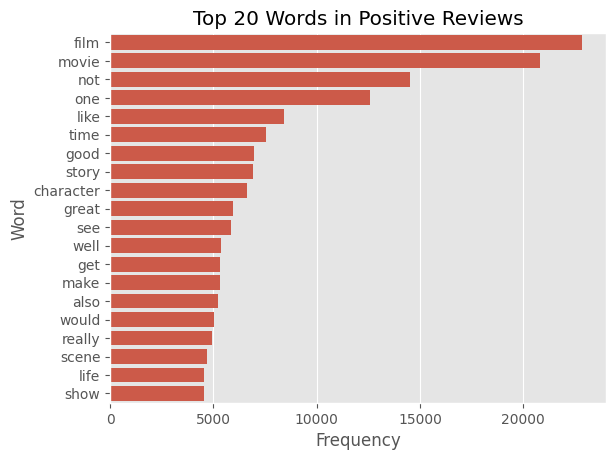

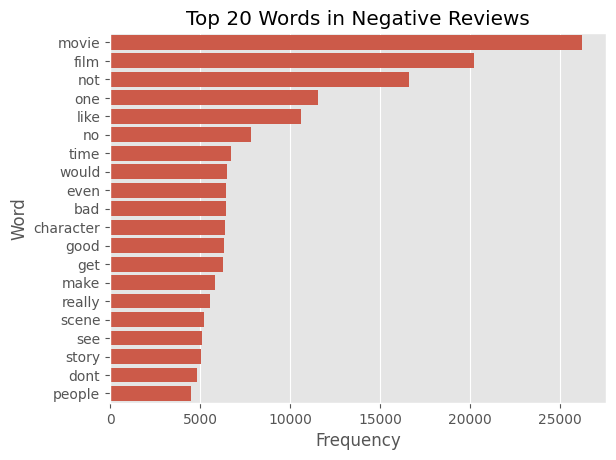

In [ ]:
# Top Words by Sentiment
def top_words_by_sentiment(label, top_n=20):
    corpus = ' '.join(df_train[df_train['label'] == label]['cleaned_text'].values)
    word_freq = pd.Series(corpus.split()).value_counts()[:top_n].reset_index()
    word_freq.columns = ['Word', 'Frequency']
    return word_freq

# Plot top words
sns.barplot(x='Frequency', y='Word', data=top_words_by_sentiment(1))
plt.title('Top 20 Words in Positive Reviews')
plt.show()

sns.barplot(x='Frequency', y='Word', data=top_words_by_sentiment(0))
plt.title('Top 20 Words in Negative Reviews')
plt.show()


In [ ]:
# Word Clouds
def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.title(title, size=15)
    plt.axis('off')
    plt.show()


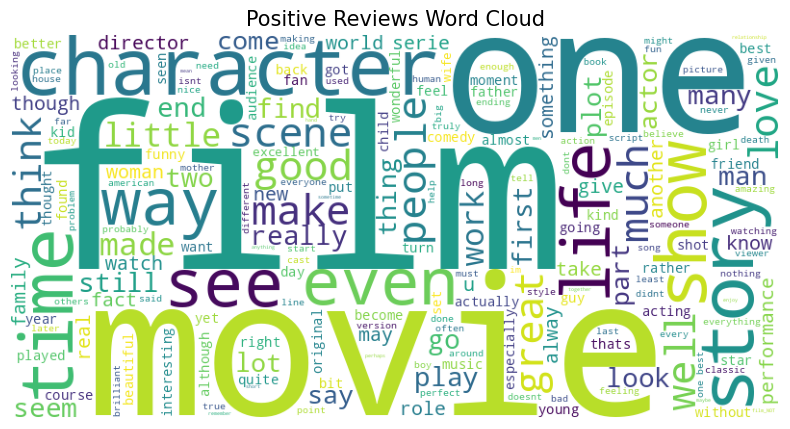

In [ ]:
# Positive reviews word cloud
positive = df_train[df_train['label'] == 1]['cleaned_text']

positive_text = ' '.join(positive)
generate_wordcloud(positive_text, 'Positive Reviews Word Cloud')

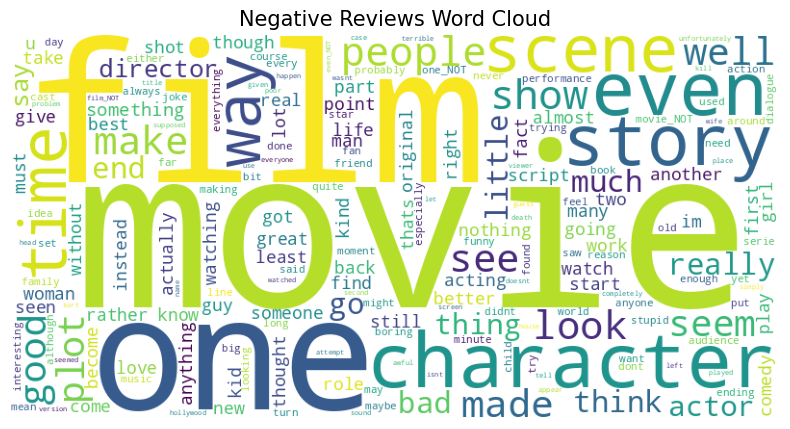

In [ ]:
# Negative reviews word cloud
negative = df_train[df_train['label'] == 0]['cleaned_text']

negative_text = ' '.join(negative)
generate_wordcloud(negative_text, 'Negative Reviews Word Cloud')

In [ ]:
from plotly.graph_objs import Figure, Treemap

def interactive_wordcloud(corpus, title):
    vec = CountVectorizer().fit(corpus)
    bow = vec.transform(corpus)
    words = vec.get_feature_names_out()
    freqs = bow.sum(axis=0).A1
    df_words = pd.DataFrame({'word': words, 'freq': freqs})
    df_words = df_words.sort_values('freq', ascending=False).head(100)

    fig = Figure(Treemap(
        labels=df_words['word'],
        parents=['']*len(df_words),
        values=df_words['freq'],
        textinfo='label+value'
    ))
    fig.update_layout(title=title)
    fig.show()

In [ ]:
interactive_wordcloud(positive, 'Positive Words')

In [ ]:
interactive_wordcloud(negative, 'Negative Words')

In [ ]:
# Bigram Analysis for Positive and Negative Review
def get_top_bigrams(corpus_list, n=20):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10000)
    X = vec.fit_transform(corpus_list)
    features = vec.get_feature_names_out()
    sums = X.sum(axis=0)
    data = [(count, phrase) for phrase, count in zip(features, sums.tolist()[0])]
    return sorted(data, reverse=True)[:n]

<ipython-input-35-bf3d1120a6d6>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-35-bf3d1120a6d6>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




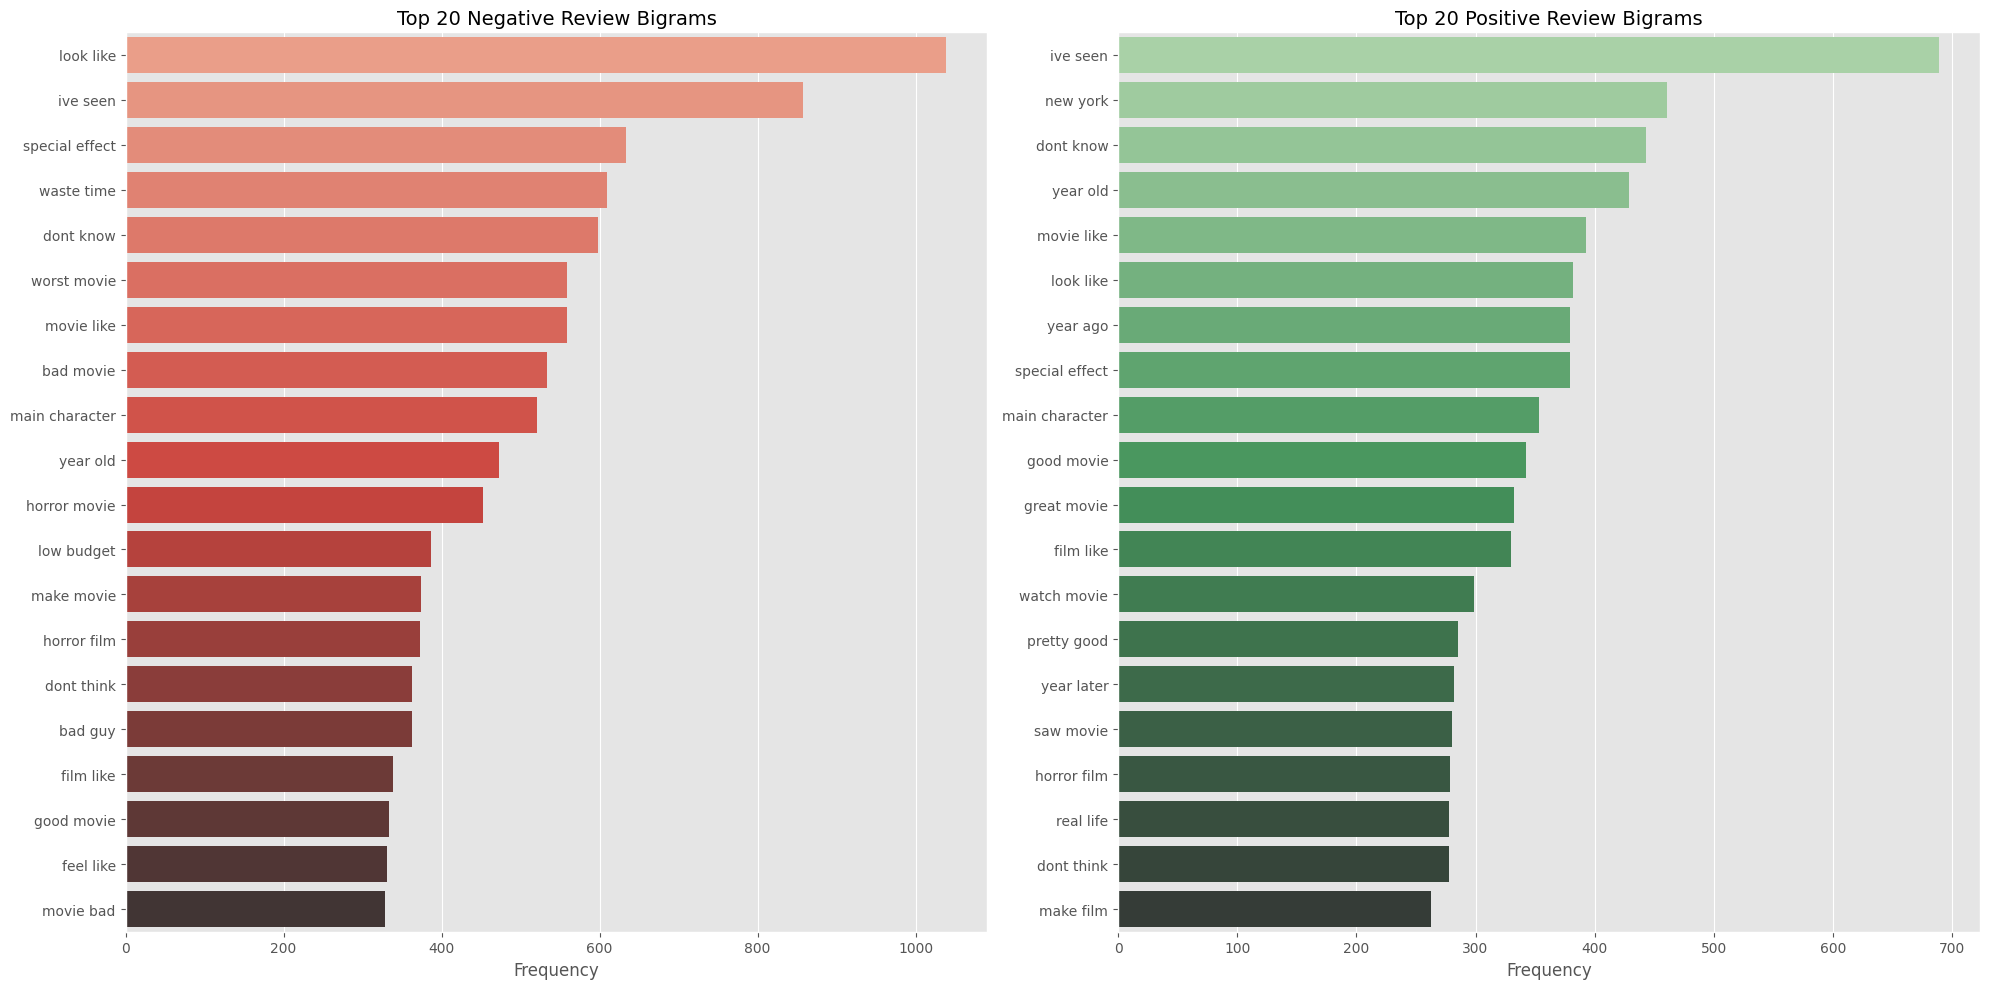

In [ ]:
# Get bigrams for both classes
negative_bigrams = get_top_bigrams(df_train[df_train['label'] == 0]['cleaned_text'].tolist())
positive_bigrams = get_top_bigrams(df_train[df_train['label'] == 1]['cleaned_text'].tolist())

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot positive bigrams
positive_df = pd.DataFrame(positive_bigrams, columns=['Frequency', 'Bi-gram'])
sns.barplot(x='Frequency', y='Bi-gram', data=positive_df, palette='Greens_d', ax=ax[1])
ax[1].set_title('Top 20 Positive Review Bigrams', fontsize=14)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('')

# Plot negative bigrams
negative_df = pd.DataFrame(negative_bigrams, columns=['Frequency', 'Bi-gram'])
sns.barplot(x='Frequency', y='Bi-gram', data=negative_df, palette='Reds_d', ax=ax[0])
ax[0].set_title('Top 20 Negative Review Bigrams', fontsize=14)
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('')


plt.tight_layout()
plt.show()

In [ ]:
# Trigram Analysis for Positive and Negative Reviews
def get_top_trigrams(corpus_list, n=20):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=10000)
    X = vec.fit_transform(corpus_list)
    features = vec.get_feature_names_out()
    sums = X.sum(axis=0)
    data = [(count, phrase) for phrase, count in zip(features, sums.tolist()[0])]
    return sorted(data, reverse=True)[:n]


<ipython-input-37-af9728e9d841>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-37-af9728e9d841>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




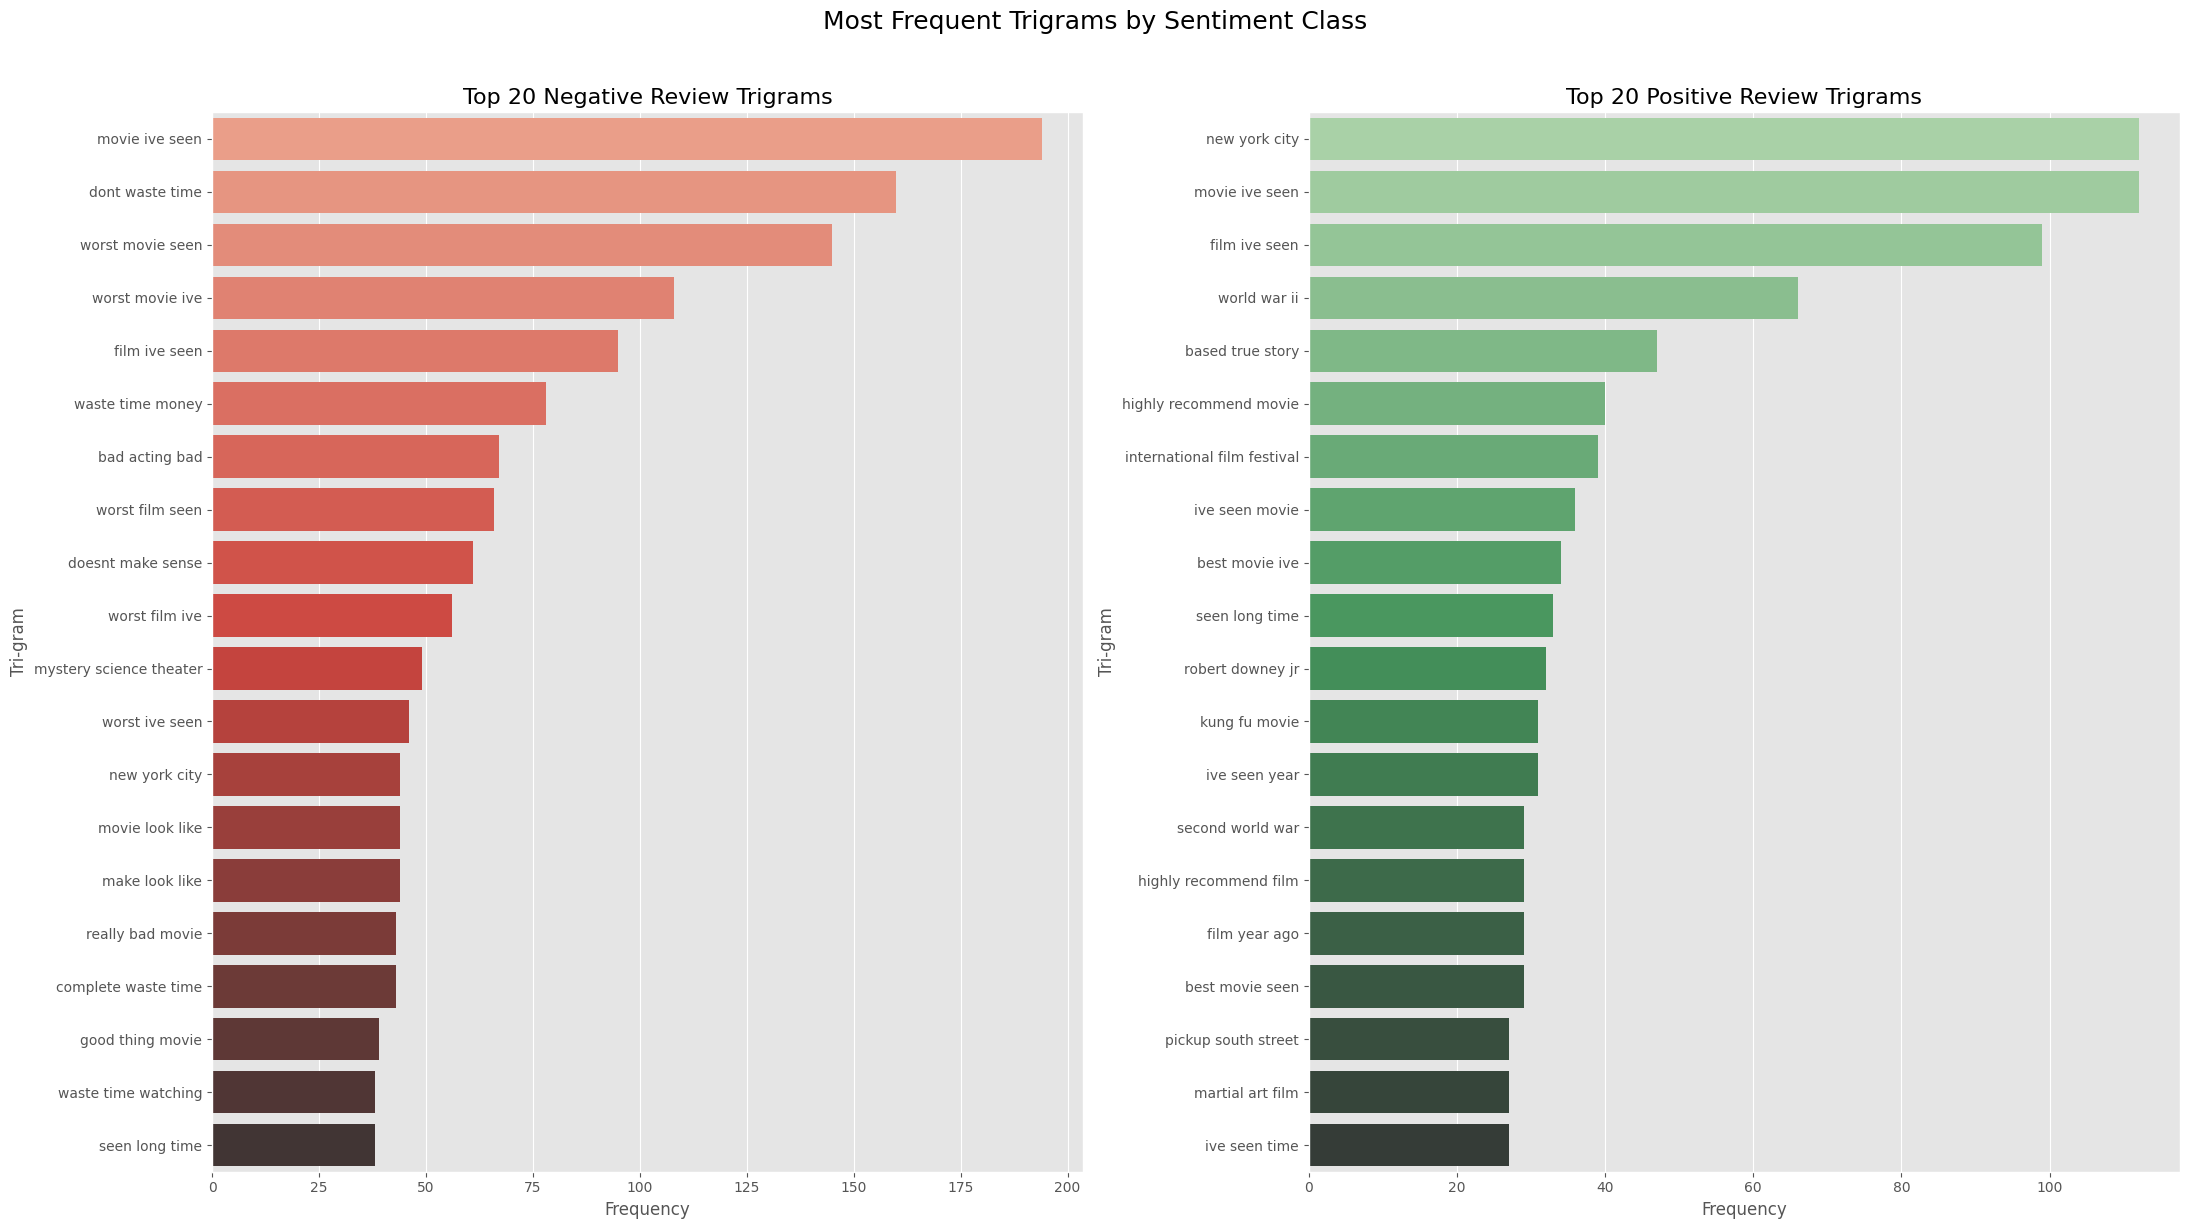

In [ ]:
# Get trigrams for both classes
negative_trigrams = get_top_trigrams(df_train[df_train['label'] == 0]['cleaned_text'].tolist())
positive_trigrams = get_top_trigrams(df_train[df_train['label'] == 1]['cleaned_text'].tolist())

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(22, 12))

# Plot positive trigrams
positive_df = pd.DataFrame(positive_trigrams, columns=['Frequency', 'Tri-gram'])  # Changed column name
sns.barplot(x='Frequency', y='Tri-gram', data=positive_df, palette='Greens_d', ax=ax[1])
ax[1].set_title('Top 20 Positive Review Trigrams', fontsize=16)  # Changed title
ax[1].set_xlabel('Frequency', fontsize=12)
ax[1].tick_params(axis='y', labelsize=10)

# Plot negative trigrams
negative_df = pd.DataFrame(negative_trigrams, columns=['Frequency', 'Tri-gram'])  # Changed column name
sns.barplot(x='Frequency', y='Tri-gram', data=negative_df, palette='Reds_d', ax=ax[0])
ax[0].set_title('Top 20 Negative Review Trigrams', fontsize=16)  # Changed title
ax[0].set_xlabel('Frequency', fontsize=12)
ax[0].tick_params(axis='y', labelsize=10)

plt.suptitle('Most Frequent Trigrams by Sentiment Class', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

## 5. Model Building
Three models are choses: Logistic Regression, Random Forest, and Linear SVM

In [ ]:
# Split the data into training and testing
X_train = df_train['cleaned_text']
y_train = df_train['label']
X_test = df_test['cleaned_text']
y_test = df_test['label']

In [ ]:
# Function of evaluation of the model
def evaluate_model(model, X_test, y_test):
    """Perform comprehensive model evaluation"""
    # Generate predictions
    y_pred = model.predict(X_test)

    # Get probability/decision scores safely
    if hasattr(model, "predict_proba"):
        # Use predict_proba for Logistic Regression, Random Forest, etc.
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    elif hasattr(model, "decision_function"):
        # Use decision_function for LinearSVC
        y_proba = model.decision_function(X_test)
    else:
        raise ValueError("Model must have either predict_proba or decision_function.")

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba)
    }

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR Curve (AP = {metrics["pr_auc"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

    # Metrics table
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
    print("\nKey Metrics:")
    display(metrics_df)

    return metrics

### 5.1 Base Model Implementation
#### Logistic Regression

In [ ]:
# Logistic Regression base model
lr_base_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

lr_base_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



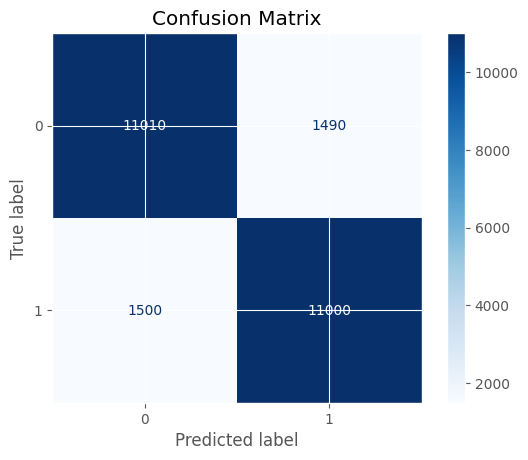

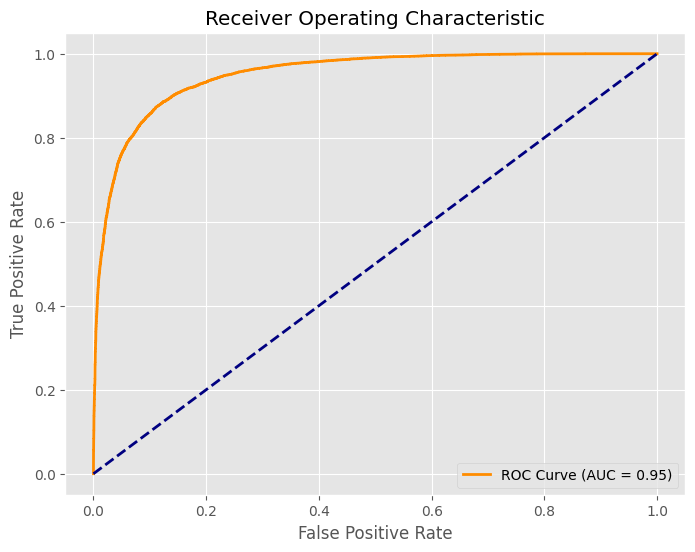

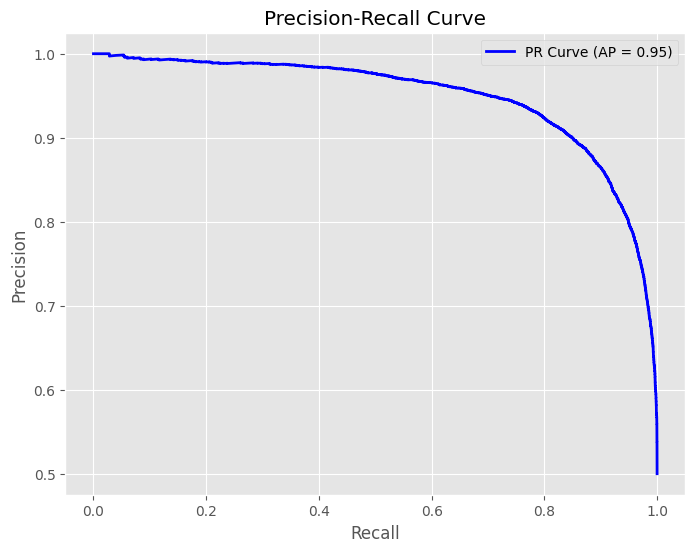


Key Metrics:


,Value
accuracy,0.880400
precision,0.880705
recall,0.880000
f1,0.880352
roc_auc,0.950400
pr_auc,0.948948


In [ ]:
# Evaluation of Logistic Regression base model
lr_base_metrics = evaluate_model(lr_base_model, X_test, y_test)

Random Forest

In [ ]:
# Random Forest Base Model Pipeline
rf_base_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD()),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_base_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svd', TruncatedSVD()),
                ('rf', RandomForestClassifier(random_state=42))])

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.58      0.56     12500
           1       0.56      0.53      0.54     12500

    accuracy                           0.55     25000
   macro avg       0.55      0.55      0.55     25000
weighted avg       0.55      0.55      0.55     25000



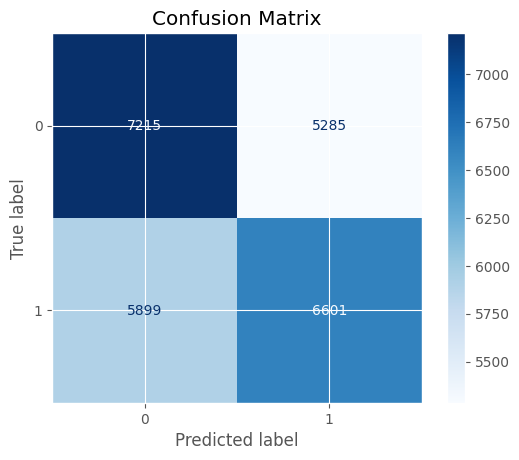

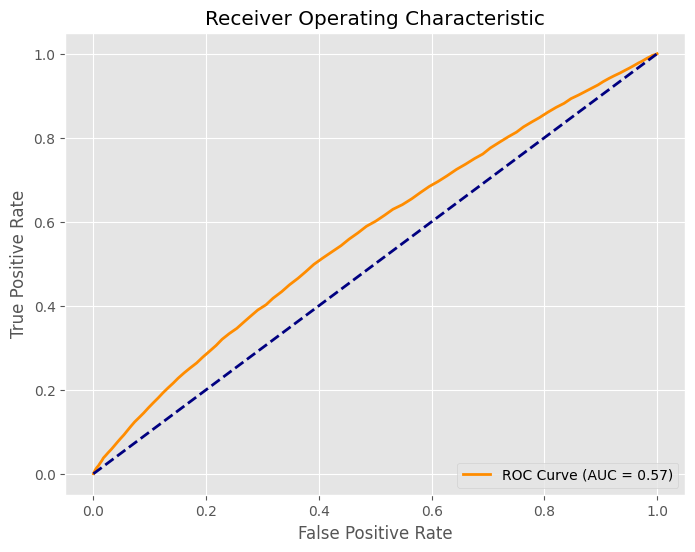

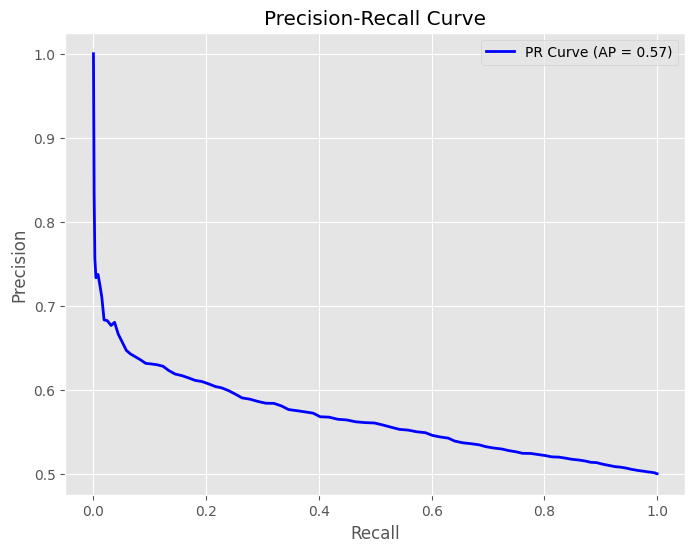


Key Metrics:


,Value
accuracy,0.552640
precision,0.555359
recall,0.528080
f1,0.541376
roc_auc,0.570479
pr_auc,0.565422


In [ ]:
# Evaluation of Random Forest base model
rf_based_metric = evaluate_model(rf_base_model, X_test, y_test)

Linear SVM

In [ ]:
# Linear SVM Base Model Pipeline
svm_base_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', LinearSVC())
])

svm_base_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svm', LinearSVC())])

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



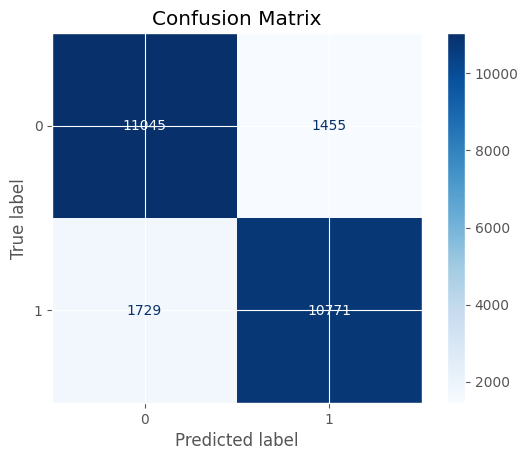

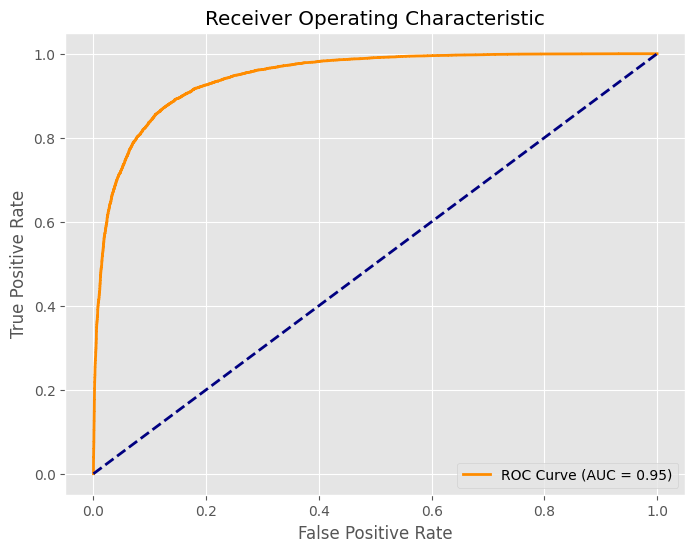

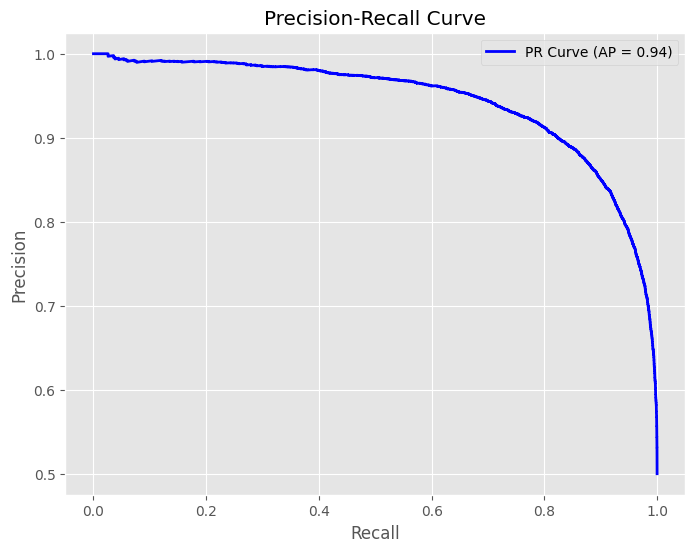


Key Metrics:


,Value
accuracy,0.872640
precision,0.880991
recall,0.861680
f1,0.871229
roc_auc,0.945910
pr_auc,0.943725


In [ ]:
# Evaluation of Linear SVM base model
svm_base_metric = evaluate_model(svm_base_model, X_test, y_test)

### 5.2 Hyperparameter Tuning

Logistic Regression

In [ ]:
# Suggested parameters for logistic regression tuning
logistic_params = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__sublinear_tf': [True],
    "lr__C": np.logspace(-4, 4, 5),
    "lr__class_weight": [None, 'balanced'],
    "lr__penalty": ['l1', 'l2'],
    "lr__solver": ['liblinear', 'saga']
}

In [ ]:
# Apply GridSearch method with 3 fold cross validation
logistic_grid_search = GridSearchCV(
    lr_base_model,
    param_grid=logistic_params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

logistic_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'lr__class_weight': [None, 'balanced'],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear', 'saga'],
                         'tfidf__max_features': [5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__sublinear_tf': [True]},
             verbose=1)

In [ ]:
logistic_best_model = logistic_grid_search.best_estimator_
print("=== Logistic Tuned Model Evaluation ===")
print(f"Best Parameters: {logistic_grid_search.best_params_}")
print(f"Cross-Val Accuracy: {logistic_grid_search.best_score_:.4f}")

=== Logistic Tuned Model Evaluation ===
Best Parameters: {'lr__C': 1.0, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}
Cross-Val Accuracy: 0.8718


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



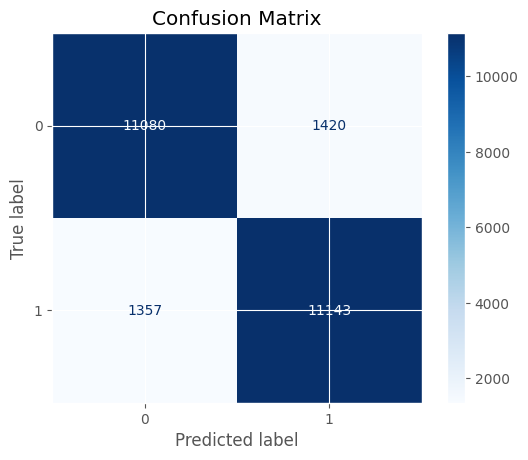

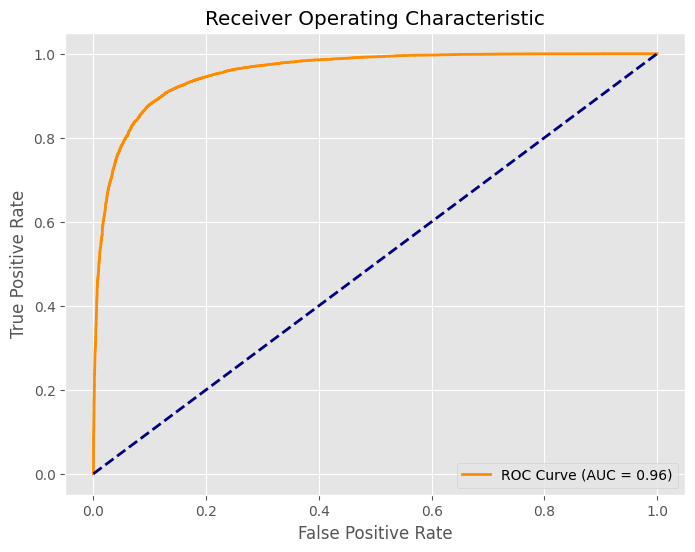

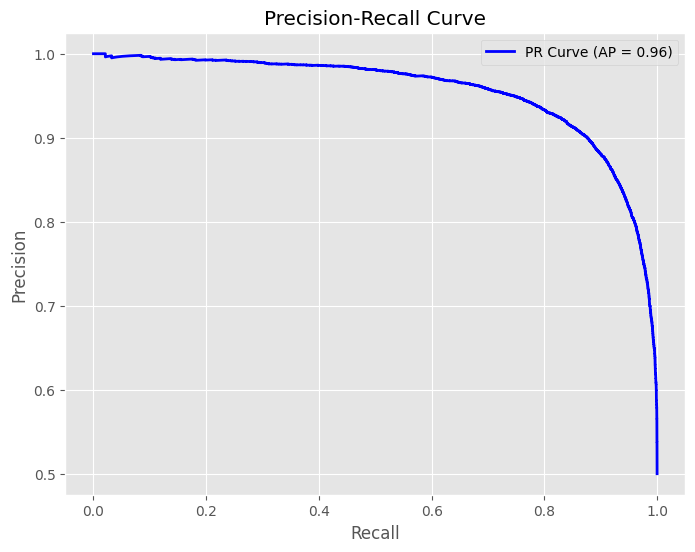


Key Metrics:


,Value
accuracy,0.888920
precision,0.886970
recall,0.891440
f1,0.889199
roc_auc,0.956574
pr_auc,0.955141


In [ ]:
# Evaluation of Logistic Regression Best model
lr_tuned_metrics = evaluate_model(logistic_best_model, X_test, y_test)

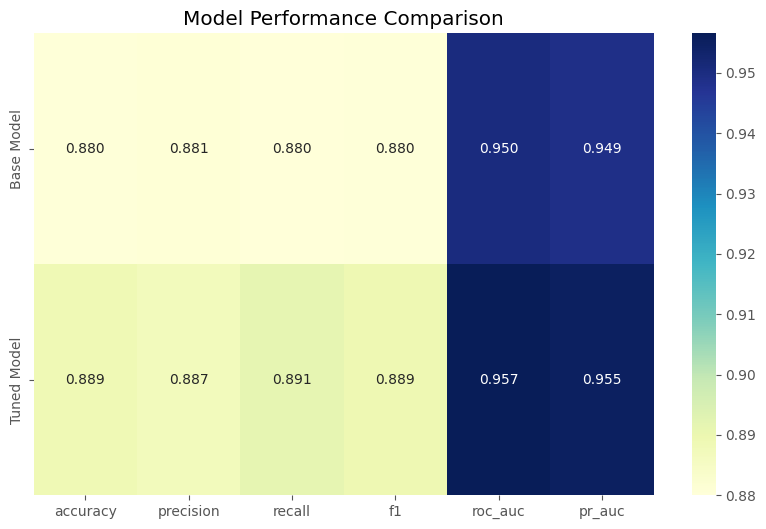

In [ ]:
  # Comparative Logistic Regression model metrics visualization
metrics_comparison = pd.DataFrame({
      'Base Model': lr_base_metrics,
      'Tuned Model': lr_tuned_metrics
  }).T

plt.figure(figsize=(10,6))
sns.heatmap(metrics_comparison, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Model Performance Comparison')
plt.show()

In [ ]:
# Deploy the best parameter
final_logistic_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=logistic_grid_search.best_params_['tfidf__max_features'],
        ngram_range=logistic_grid_search.best_params_['tfidf__ngram_range'],
        sublinear_tf=logistic_grid_search.best_params_['tfidf__sublinear_tf']
    )),
    ('lr', LogisticRegression(
        C=logistic_grid_search.best_params_['lr__C'],
        penalty=logistic_grid_search.best_params_['lr__penalty'],
        solver=logistic_grid_search.best_params_['lr__solver'],
        class_weight=logistic_grid_search.best_params_['lr__class_weight']  # Optional: Include if you used it during tuning
    ))
])


In [ ]:
# Retrain on full data
final_logistic_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# Save for deployment
joblib.dump(final_logistic_model, 'final_logistic_model_v2.pkl')

# Example Prediction
sample_text = ["This movie is not bad at all"]
print("\nExample Prediction:", final_logistic_model.predict(sample_text)[0])
print("Decision Function Score:", final_logistic_model.predict_proba(sample_text)[0])


Example Prediction: 1
Decision Function Score: [0.21867523 0.78132477]


In [ ]:
sample_text = ["This movie is not good_NOT"]
print("\nExample Prediction:", final_logistic_model.predict(sample_text)[0])
print("Decision Function Score:", final_logistic_model.predict_proba(sample_text)[0])


Example Prediction: 0
Decision Function Score: [0.95531744 0.04468256]


Random Forest

In [ ]:
# PHASE 1: Core parameters (24 combinations)
rf_phase1_params = {
    'tfidf__max_features': [5000, 10000],
    'svd__n_components': [100, 300],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [20, 30]
}


In [ ]:
# PHASE 1: Core parameters
phase1_search = GridSearchCV(
    rf_base_model,
    rf_phase1_params,
    cv=3,
    n_jobs=-1,
    verbose=1
    )

phase1_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svd', TruncatedSVD(n_components=100)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 30],
                         'rf__n_estimators': [100, 200],
                         'svd__n_components': [100, 300],
                         'tfidf__max_features': [5000, 10000]},
             verbose=1)

In [ ]:
print("Phase 1 Best Params:", phase1_search.best_params_)

Phase 1 Best Params: {'rf__max_depth': 30, 'rf__n_estimators': 200, 'svd__n_components': 100, 'tfidf__max_features': 10000}


In [ ]:
# PHASE 2: Use best params from Phase 1 as FIXED values
rf_phase2_params = {
    'rf__max_features': ['sqrt', 0.7],
    'rf__min_samples_split': [2, 5]
}



In [ ]:
# Create new pipeline with Phase 1 best params
phase2_pipeline = clone(rf_base_model).set_params(**phase1_search.best_params_)

phase2_search = GridSearchCV(
    phase2_pipeline,
    rf_phase2_params,
    cv=3,
    n_jobs=-1,
    verbose=1
    )

phase2_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000)),
                                       ('svd', TruncatedSVD(n_components=100)),
                                       ('rf',
                                        RandomForestClassifier(max_depth=30,
                                                               n_estimators=200,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_features': ['sqrt', 0.7],
                         'rf__min_samples_split': [2, 5]},
             verbose=1)

In [ ]:
print("Phase 2 Best Params:", phase2_search.best_params_)

Phase 2 Best Params: {'rf__max_features': 0.7, 'rf__min_samples_split': 5}


In [ ]:
# PHASE 3: Final tuning (96×2×2=384 combos)
rf_final_params = {
    'rf__class_weight': [None, 'balanced'],
    'rf__bootstrap': [True, False]
}

In [ ]:
phase3_pipeline = clone(phase2_search.best_estimator_).set_params(**phase2_search.best_params_)

phase3_search = GridSearchCV(
    phase3_pipeline,
    rf_final_params,
    cv=3,
    n_jobs=-1,
    verbose=1)

phase3_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000)),
                                       ('svd', TruncatedSVD(n_components=100)),
                                       ('rf',
                                        RandomForestClassifier(max_depth=30,
                                                               max_features=0.7,
                                                               min_samples_split=5,
                                                               n_estimators=200,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [True, False],
                         'rf__class_weight': [None, 'balanced']},
             verbose=1)

In [ ]:
print("Phase 3 Best Params:", phase3_search.best_params_)

Phase 3 Best Params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced'}


In [ ]:
rf_final_model = phase3_search.best_estimator_
print("Final Model Parameters:")
print(rf_final_model.named_steps['rf'].get_params())
print(f"Cross-Val Accuracy: {phase3_search.best_score_:.4f}")

Final Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Cross-Val Accuracy: 0.8030


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     12500
           1       0.81      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



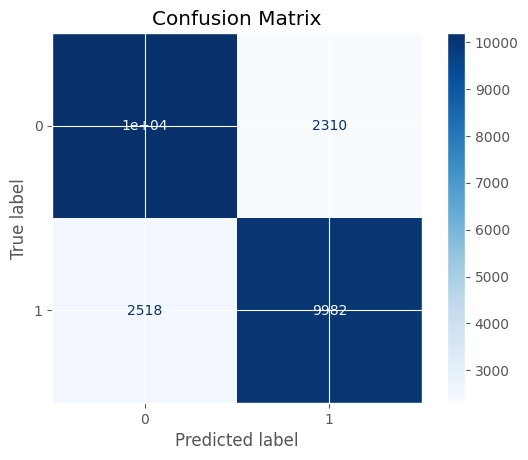

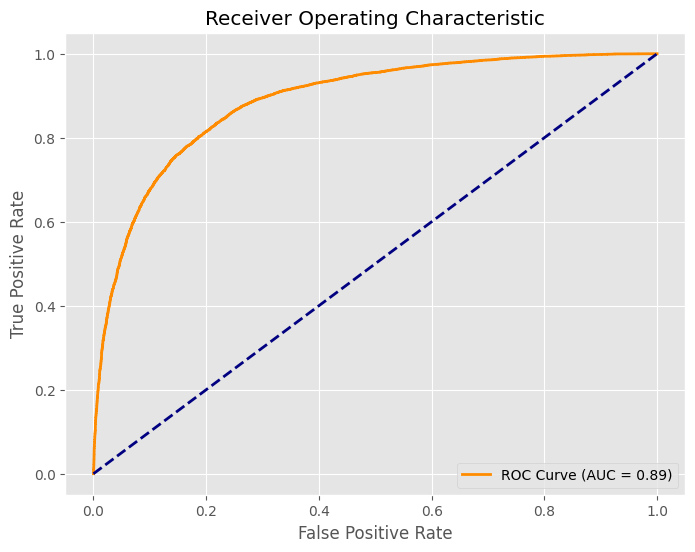

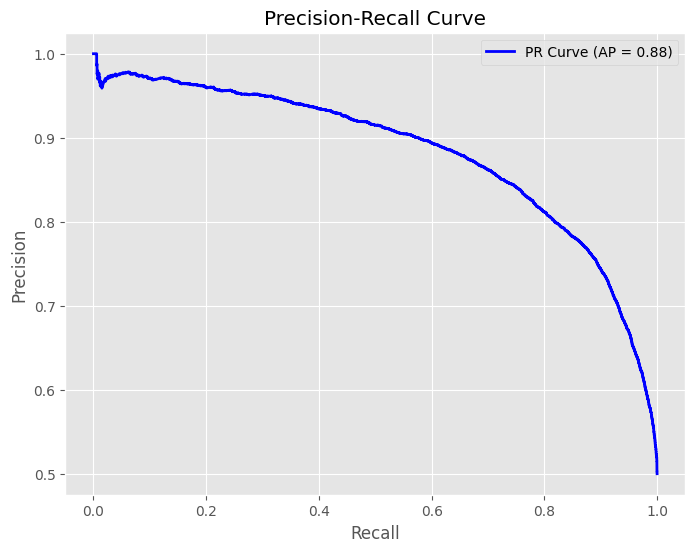


Key Metrics:


,Value
accuracy,0.806880
precision,0.812073
recall,0.798560
f1,0.805260
roc_auc,0.888051
pr_auc,0.882643


In [ ]:
rf_tuned_metrics = evaluate_model(rf_final_model, X_test, y_test)

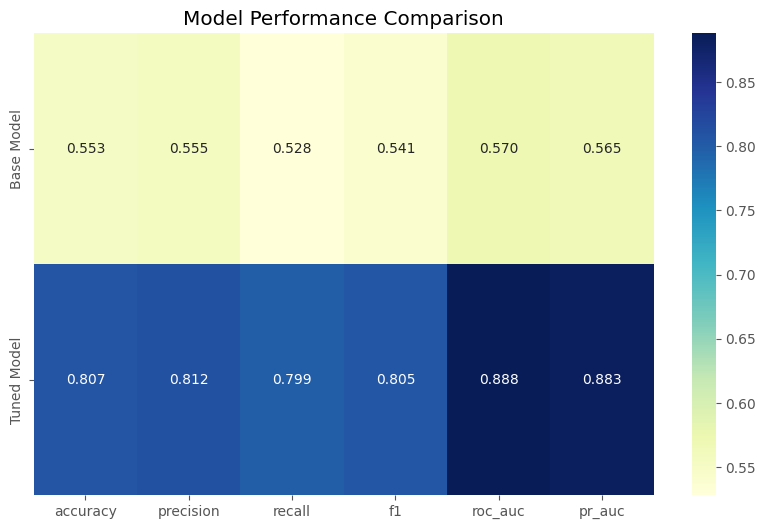

In [ ]:
# Comparative Random Forest model metrics visualization
metrics_comparison = pd.DataFrame({
      'Base Model': rf_based_metric,
      'Tuned Model': rf_tuned_metrics
  }).T

plt.figure(figsize=(10,6))
sns.heatmap(metrics_comparison, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Model Performance Comparison')
plt.show()

In [ ]:
final_rf_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=phase1_search.best_params_['tfidf__max_features']
    )),
    ('svd', TruncatedSVD(
        n_components=phase1_search.best_params_['svd__n_components']
    )),
    ('rf', RandomForestClassifier(
        n_estimators=phase1_search.best_params_['rf__n_estimators'],
        max_depth=phase1_search.best_params_['rf__max_depth'],
        max_features=phase2_search.best_params_['rf__max_features'],
        min_samples_split=phase2_search.best_params_['rf__min_samples_split'],
        class_weight=phase3_search.best_params_['rf__class_weight'],
        bootstrap=phase3_search.best_params_['rf__bootstrap'],
        random_state=42,
        n_jobs=-1
    ))
])


In [ ]:
# Retrain on full data
final_rf_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# Save for deployment
joblib.dump(final_rf_model, 'final_rf_model_v2.pkl')

In [ ]:
# Example Prediction
sample_text = ["This movie one of the best movie i have ever watch"]
print("\nExample Prediction:", final_rf_model.predict(sample_text)[0])
print("Class Probabilities:", final_rf_model.predict_proba(sample_text)[0])
print(f"Confidence: {max(final_rf_model.predict_proba(sample_text)[0])*100:.1f}%")


Example Prediction: 1
Class Probabilities: [0.43312897 0.56687103]
Confidence: 56.7%


Linear SVM

In [ ]:
# Enhanced Parameter Grid for LinearSVC
liner_svm_params = {
    'tfidf__max_features': [5000, 10000, 15000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__sublinear_tf': [True, False],
    'svm__C': np.logspace(-2, 2, 5),
    'svm__class_weight': [None, 'balanced'],
    'svm__loss': ['squared_hinge'],
    'svm__dual': [True, False]
}


In [ ]:
# Randome Search with higher iteration
svm_random_search = RandomizedSearchCV(
    svm_base_model,
    liner_svm_params,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
svm_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('svm', LinearSVC())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'svm__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'svm__class_weight': [None, 'balanced'],
                                        'svm__dual': [True, False],
                                        'svm__loss': ['squared_hinge'],
                                        'tfidf__max_features': [5000, 10000,
                                                                15000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__sublinear_tf': [True, False]},
                   random_state=42, verbose=1)

In [ ]:
# Linear SVM Best Model Analysis
linear_svm_best_model = svm_random_search.best_estimator_
print("\n=== Tuned Model Evaluation ===")
print(f"Best Parameters: {svm_random_search.best_params_}")
print(f"Cross-Val Accuracy: {svm_random_search.best_score_:.4f}")


=== Tuned Model Evaluation ===
Best Parameters: {'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 5000, 'svm__loss': 'squared_hinge', 'svm__dual': False, 'svm__class_weight': 'balanced', 'svm__C': 0.1}
Cross-Val Accuracy: 0.8697


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     12500
           1       0.88      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



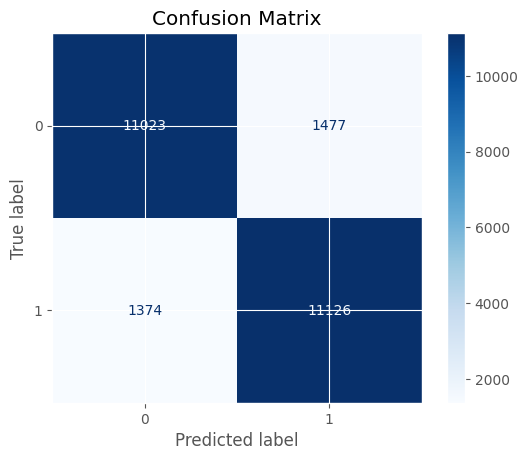

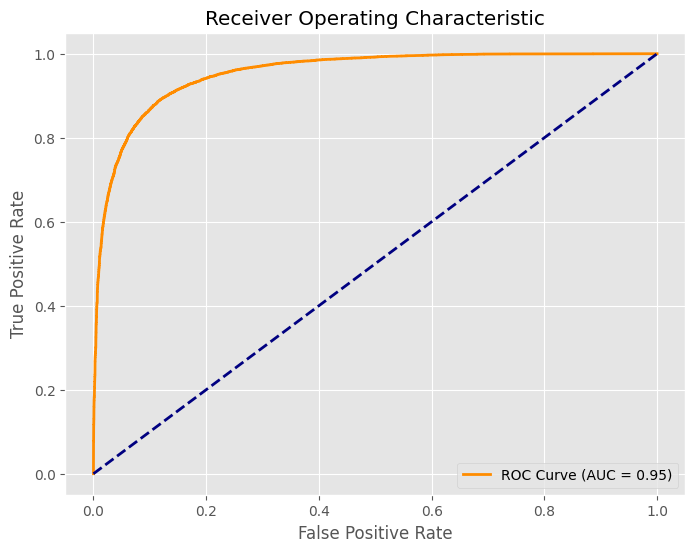

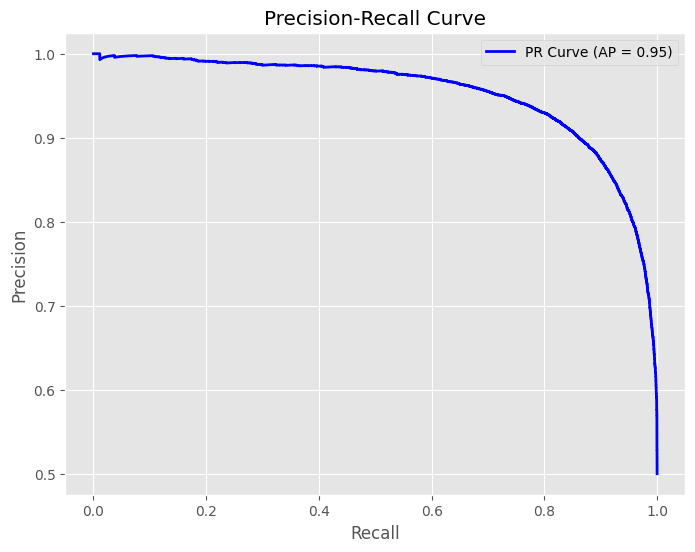


Key Metrics:


,Value
accuracy,0.885960
precision,0.882806
recall,0.890080
f1,0.886428
roc_auc,0.954462
pr_auc,0.952906


In [ ]:
linear_svm_tuned_metric = evaluate_model(linear_svm_best_model, X_test, y_test)

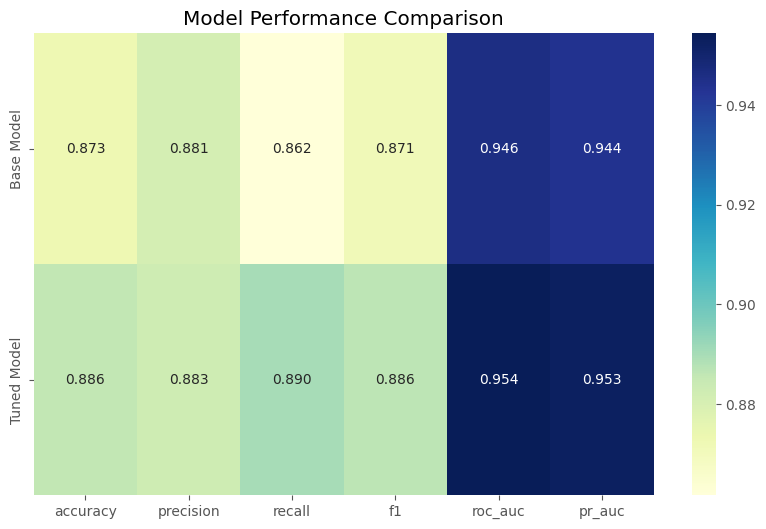

In [ ]:
# Comparative Linear SVM model metrics visualization
metrics_comparison = pd.DataFrame({
      'Base Model': svm_base_metric,
      'Tuned Model': linear_svm_tuned_metric
  }).T

plt.figure(figsize=(10,6))
sns.heatmap(metrics_comparison, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Model Performance Comparison')
plt.show()

In [ ]:
# Final Production Pipeline SVM
linear_svm_final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=svm_random_search.best_params_['tfidf__max_features'],
        ngram_range=svm_random_search.best_params_['tfidf__ngram_range'],
        sublinear_tf=svm_random_search.best_params_['tfidf__sublinear_tf']
    )),
    ('svm', LinearSVC(
        C=svm_random_search.best_params_['svm__C'],
        class_weight=svm_random_search.best_params_['svm__class_weight'],
        loss=svm_random_search.best_params_['svm__loss'],
        dual=svm_random_search.best_params_['svm__dual']

    ))
])


In [ ]:
# Retrain on full data
linear_svm_final_pipeline.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# Save for deployment
joblib.dump(linear_svm_final_pipeline, 'final_linearsvm_model_v2.pkl')

# Example Prediction
sample_text = ["This movie was an absolute masterpiece!"]
print("\nExample Prediction:", linear_svm_final_pipeline.predict(sample_text)[0])
print("Decision Function Score:", linear_svm_final_pipeline.decision_function(sample_text)[0])


Example Prediction: 1
Decision Function Score: 0.5008623366847637
